In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Warnings off (clean output)
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("customer_churn.csv")
df.head()


,CustomerID,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,PaperlessBilling,SeniorCitizen,Churn
0,C00001,6,64,1540,One year,Credit Card,No,1,0
1,C00002,21,113,1753,Month-to-month,Electronic Check,Yes,1,0
2,C00003,27,31,1455,Two year,Credit Card,No,1,0
3,C00004,53,29,7150,Month-to-month,Electronic Check,No,1,0
4,C00005,16,185,1023,One year,Electronic Check,No,1,0


In [3]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        500 non-null    object
 1   Tenure            500 non-null    int64 
 2   MonthlyCharges    500 non-null    int64 
 3   TotalCharges      500 non-null    int64 
 4   Contract          500 non-null    object
 5   PaymentMethod     500 non-null    object
 6   PaperlessBilling  500 non-null    object
 7   SeniorCitizen     500 non-null    int64 
 8   Churn             500 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 35.3+ KB


,0
CustomerID,0
Tenure,0
MonthlyCharges,0
TotalCharges,0
Contract,0
PaymentMethod,0
PaperlessBilling,0
SeniorCitizen,0
Churn,0


In [4]:
# Drop duplicates (yes, they matter)
df = df.drop_duplicates()

# Fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)


In [5]:
le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop("Churn", axis=1))


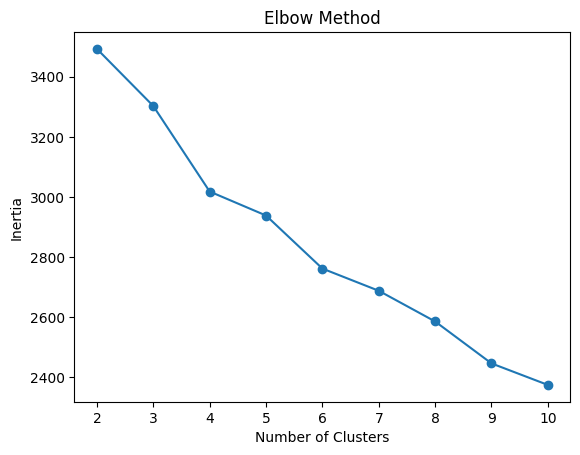

In [7]:
inertia = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster_KMeans"] = kmeans.fit_predict(scaled_features)

silhouette_score(scaled_features, df["Cluster_KMeans"])


np.float64(0.09836194468655049)

In [9]:
hc = AgglomerativeClustering(n_clusters=3)
df["Cluster_Hierarchical"] = hc.fit_predict(scaled_features)


In [10]:
dbscan = DBSCAN(eps=1.2, min_samples=5)
df["Cluster_DBSCAN"] = dbscan.fit_predict(scaled_features)


In [11]:
df["Final_Cluster"] = df["Cluster_KMeans"]


In [12]:
segment_profiles = df.groupby("Final_Cluster").mean()
segment_profiles


,CustomerID,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,PaperlessBilling,SeniorCitizen,Churn,Cluster_KMeans,Cluster_Hierarchical,Cluster_DBSCAN
Final_Cluster,,,,,,,,,,,,
0,240.470588,47.067227,116.655462,3120.470588,0.411765,0.789916,0.226891,0.117647,0.050420,0.0,1.033613,-1.000000
1,252.604255,34.468085,107.438298,4449.272340,1.004255,0.991489,0.497872,1.000000,0.106383,1.0,0.127660,-1.000000
2,251.863014,31.267123,121.150685,4808.397260,1.294521,1.212329,0.678082,0.000000,0.150685,2.0,1.383562,-0.965753


In [14]:
segment_profiles.to_csv("segmentation_data.csv")


In [15]:
def train_evaluate_model(data, segment_id):
    segment_data = data[data["Final_Cluster"] == segment_id]

    X = segment_data.drop(["Churn", "Final_Cluster",
                            "Cluster_KMeans",
                            "Cluster_Hierarchical",
                            "Cluster_DBSCAN"], axis=1, errors='ignore')
    y = segment_data["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Segment": segment_id,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }


In [16]:
results = []

for segment in df["Final_Cluster"].unique():
    results.append(train_evaluate_model(df, segment))

results_df = pd.DataFrame(results)
results_df


,Segment,Accuracy,Precision,Recall,F1,ROC_AUC
0,1,0.957447,0.833333,0.833333,0.833333,0.995935
1,2,0.966667,0.800000,1.000000,0.888889,0.961538
2,0,0.833333,0.000000,0.000000,0.000000,1.000000


In [17]:
results_df.to_csv("model_evaluation_results.csv", index=False)


In [18]:
segment_0 = df[df["Final_Cluster"] == 0]

X = segment_0.drop(["Churn", "Final_Cluster",
                    "Cluster_KMeans",
                    "Cluster_Hierarchical",
                    "Cluster_DBSCAN"], axis=1, errors='ignore')
y = segment_0["Churn"]

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="f1"
)

grid.fit(X, y)
grid.best_params_


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

In [19]:
best_model = grid.best_estimator_

importances = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(10)


,0
Tenure,0.592384
MonthlyCharges,0.123586
CustomerID,0.106066
TotalCharges,0.092090
PaymentMethod,0.037617
Contract,0.036510
PaperlessBilling,0.007000
SeniorCitizen,0.004747
